"""
# 📊 Error Analysis - Vehicle Document Classification
## Understanding Model Failures to Achieve 92%+ Accuracy

**Current Performance**: 87.67% (9 errors out of 73 test samples)  
**Goal**: Identify error patterns and implement targeted improvements  
**Target**: 92%+ accuracy (≤6 errors)

### Analysis Workflow:
1. Load model and test data
2. Identify misclassified samples  
3. Analyze error patterns by class
4. Visual inspection of failed cases
5. Statistical analysis of errors
6. Targeted improvement recommendations
"""

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set up logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("🔧 Environment Setup Complete")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-07-23 11:04:46.389247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 11:04:46.389383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 11:04:46.431974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 11:04:46.520628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-23 11:04:47.403263: W tensorflow/compiler/tf2

🔧 Environment Setup Complete
TensorFlow: 2.15.0
GPU Available: []


2025-07-23 11:04:49.292731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-23 11:04:49.641816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
PROJECT_ROOT = Path("..")
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "car_plates"
MODELS_DIR = PROJECT_ROOT / "models"
ANNOTATIONS_DIR = DATA_DIR / "annotations"

# Class configuration (matching your setup)
CLASS_NAMES = ['document', 'licence', 'odometer']
CLASS_TO_INT = {'document': 0, 'licence': 1, 'odometer': 2}
INT_TO_CLASS = {0: 'document', 1: 'licence', 2: 'odometer'}

# Model paths
MODEL_PATH = MODELS_DIR / "cpu_model.h5"
RESULTS_PATH = MODELS_DIR / "final_evaluation_report.json"

print("📁 Project Configuration:")
print(f"Data Directory: {DATA_DIR}")
print(f"Model Path: {MODEL_PATH}")
print(f"Classes: {CLASS_NAMES}")

📁 Project Configuration:
Data Directory: ../data/processed/car_plates
Model Path: ../models/cpu_model.h5
Classes: ['document', 'licence', 'odometer']


In [12]:
# Load the trained model
print("🧠 Loading trained model...")
if MODEL_PATH.exists():
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"✅ Model loaded: {model.name}")
    print(f"📊 Parameters: {model.count_params():,}")
    model.summary()
else:
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

# Load evaluation results
print("\n📊 Loading evaluation results...")
if RESULTS_PATH.exists():
    with open(RESULTS_PATH, 'r') as f:
        eval_results = json.load(f)
    
    current_accuracy = eval_results['final_metrics']['test_accuracy']
    confusion_matrix = np.array(eval_results['confusion_matrix'])
    
    print(f"✅ Current Accuracy: {current_accuracy:.4f} ({current_accuracy*100:.2f}%)")
    print(f"📈 Confusion Matrix Shape: {confusion_matrix.shape}")
else:
    print("⚠️ Evaluation results not found, will compute fresh")
    eval_results = None

🧠 Loading trained model...
✅ Model loaded: CPU_VehicleClassifier_Augmented
📊 Parameters: 160,451
Model: "CPU_VehicleClassifier_Augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation_layers (  (None, 224, 224, 3)       0         
 Sequential)                                                     
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D) 

In [6]:
# Load test split annotations
print("📋 Loading test data annotations...")
test_annotations_path = ANNOTATIONS_DIR / "test_balanced_final.json"

if test_annotations_path.exists():
    with open(test_annotations_path, 'r') as f:
        test_annotations = json.load(f)
    
    print(f"✅ Test annotations loaded: {len(test_annotations)} samples")
    
    # Display sample annotation structure
    if test_annotations:
        print("\n📄 Sample annotation structure:")
        sample = test_annotations[0]
        for key, value in sample.items():
            print(f"  {key}: {value}")
else:
    raise FileNotFoundError(f"Test annotations not found: {test_annotations_path}")

# Extract class distribution in test set
test_class_counts = defaultdict(int)
for item in test_annotations:
    # Extract class from filename (matching your naming convention)
    filename = Path(item['enhanced_path']).stem
    if filename.startswith('document'):
        class_name = 'document'
    elif filename.startswith('plate'):
        class_name = 'licence'
    elif filename.startswith('odometer'):
        class_name = 'odometer'
    else:
        continue
    test_class_counts[class_name] += 1

print(f"\n📊 Test Set Distribution:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count} samples")

📋 Loading test data annotations...
✅ Test annotations loaded: 73 samples

📄 Sample annotation structure:
  id: 2029
  original_file: 20210326_07_13_24_000_oGjWZemhevUdG7EgA8x4JDt4U2F3_F_3000_4000.jpg
  full_image_path: 
  roi_path: data/processed/car_plates/images_rois/odometer_0029_roi.jpg
  enhanced_path: data/processed/car_plates/images_rois/odometer_0029_enhanced.jpg
  bbox: {'xmin': 0, 'ymin': 0, 'xmax': 224, 'ymax': 224, 'width': 224, 'height': 224}
  class: odometer
  image_size: {'original': {'width': 3000, 'height': 4000}, 'processed': {'width': 224, 'height': 224}, 'roi': {'width': 224, 'height': 224}}
  source_dataset: odometer_dataset
  relative_path: bike and car odometer/bike/20210326_07_13_24_000_oGjWZemhevUdG7EgA8x4JDt4U2F3_F_3000_4000.jpg

📊 Test Set Distribution:
  odometer: 18 samples
  licence: 47 samples
  document: 8 samples


In [7]:
def load_and_preprocess_image(image_path):
    """Load and preprocess image for model prediction"""
    # Read image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to model input size
    image = cv2.resize(image, (224, 224))
    
    # Normalize to [0, 1] and add batch dimension
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    
    return image

def extract_class_from_filename(filename):
    """Extract true class from filename"""
    if filename.startswith('document'):
        return 'document'
    elif filename.startswith('plate'):
        return 'licence'
    elif filename.startswith('odometer'):
        return 'odometer'
    else:
        raise ValueError(f"Unknown class in filename: {filename}")

def predict_single_image(image_path):
    """Make prediction on single image"""
    image = load_and_preprocess_image(image_path)
    predictions = model.predict(image, verbose=0)
    
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = CLASS_NAMES[predicted_class_idx]
    
    return {
        'predicted_class': predicted_class,
        'predicted_idx': predicted_class_idx,
        'confidence': float(confidence),
        'all_probabilities': predictions[0].tolist()
    }

print("🔧 Prediction functions defined")

🔧 Prediction functions defined


In [14]:
print("🔍 Generating fresh predictions on test set...")

# Store all predictions and ground truth
all_predictions = []
all_ground_truth = []
detailed_results = []

# Process each test sample
for i, item in enumerate(test_annotations):
    # Get image path
    image_path = item['enhanced_path']
    
    # Fix path issues - try multiple path strategies
    if not Path(image_path).exists():
        # Strategy 1: Try with PROJECT_ROOT prefix
        alt_path1 = PROJECT_ROOT / image_path
        if alt_path1.exists():
            image_path = str(alt_path1)
        else:
            # Strategy 2: Try roi_path instead of enhanced_path
            roi_path = item.get('roi_path', '')
            if roi_path and Path(roi_path).exists():
                image_path = roi_path
            elif roi_path:
                alt_roi_path = PROJECT_ROOT / roi_path
                if alt_roi_path.exists():
                    image_path = str(alt_roi_path)
                else:
                    print(f"⚠️ Image not found: {image_path} (tried roi_path: {roi_path})")
                    continue
            else:
                print(f"⚠️ Image not found: {image_path}")
                continue
    
    try:
        # Extract true class
        filename = Path(image_path).stem
        true_class = extract_class_from_filename(filename)
        true_class_idx = CLASS_TO_INT[true_class]
        
        # Make prediction
        pred_result = predict_single_image(image_path)
        
        # Store results
        all_predictions.append(pred_result['predicted_idx'])
        all_ground_truth.append(true_class_idx)
        
        # Store detailed result
        detailed_results.append({
            'image_path': image_path,
            'filename': filename,
            'true_class': true_class,
            'true_class_idx': true_class_idx,
            'predicted_class': pred_result['predicted_class'],
            'predicted_idx': pred_result['predicted_idx'],
            'confidence': pred_result['confidence'],
            'is_correct': pred_result['predicted_idx'] == true_class_idx,
            'all_probabilities': pred_result['all_probabilities']
        })
        
        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(test_annotations)} samples...")
            
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        continue

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)

# Calculate fresh accuracy
fresh_accuracy = np.mean(all_predictions == all_ground_truth)
num_errors = np.sum(all_predictions != all_ground_truth)

print(f"\n📊 Fresh Prediction Results:")
print(f"  Total samples: {len(all_predictions)}")
print(f"  Accuracy: {fresh_accuracy:.4f} ({fresh_accuracy*100:.2f}%)")
print(f"  Errors: {num_errors}/{len(all_predictions)}")

🔍 Generating fresh predictions on test set...
  Processed 20/73 samples...
  Processed 40/73 samples...
  Processed 60/73 samples...

📊 Fresh Prediction Results:
  Total samples: 73
  Accuracy: 0.9178 (91.78%)
  Errors: 6/73


In [15]:
print("🔍 Analyzing Error Cases...")

# Filter error cases
error_cases = [result for result in detailed_results if not result['is_correct']]
correct_cases = [result for result in detailed_results if result['is_correct']]

print(f"\n📊 Error Analysis Summary:")
print(f"  Total errors: {len(error_cases)}")
print(f"  Total correct: {len(correct_cases)}")

if len(error_cases) > 0:
    print(f"\n🚨 Individual Error Cases:")
    for i, error in enumerate(error_cases, 1):
        print(f"\n  Error #{i}:")
        print(f"    File: {error['filename']}")
        print(f"    True: {error['true_class']} → Predicted: {error['predicted_class']}")
        print(f"    Confidence: {error['confidence']:.3f}")
        print(f"    Probabilities: {[f'{p:.3f}' for p in error['all_probabilities']]}")

🔍 Analyzing Error Cases...

📊 Error Analysis Summary:
  Total errors: 6
  Total correct: 67

🚨 Individual Error Cases:

  Error #1:
    File: odometer_0029_enhanced
    True: odometer → Predicted: licence
    Confidence: 0.693
    Probabilities: ['0.030', '0.693', '0.276']

  Error #2:
    File: odometer_0154_enhanced
    True: odometer → Predicted: document
    Confidence: 0.504
    Probabilities: ['0.504', '0.122', '0.373']

  Error #3:
    File: odometer_0127_enhanced
    True: odometer → Predicted: document
    Confidence: 0.504
    Probabilities: ['0.504', '0.122', '0.373']

  Error #4:
    File: odometer_0051_enhanced
    True: odometer → Predicted: licence
    Confidence: 0.515
    Probabilities: ['0.032', '0.515', '0.453']

  Error #5:
    File: document_aug_10_01_rotate_-5_roi
    True: document → Predicted: licence
    Confidence: 0.938
    Probabilities: ['0.024', '0.938', '0.039']

  Error #6:
    File: plate_0233_enhanced
    True: licence → Predicted: document
    Confide

In [16]:
print("📈 Analyzing Error Patterns...")

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
print(f"\n📊 Confusion Matrix:")
print(f"    Predicted: {CLASS_NAMES}")
for i, true_class in enumerate(CLASS_NAMES):
    print(f"  {true_class:10}: {conf_matrix[i]}")

# Analyze error patterns by class
error_patterns = defaultdict(list)
for error in error_cases:
    key = f"{error['true_class']} → {error['predicted_class']}"
    error_patterns[key].append(error)

print(f"\n🔍 Error Patterns:")
for pattern, cases in error_patterns.items():
    print(f"  {pattern}: {len(cases)} cases")
    if len(cases) <= 3:  # Show details for small error groups
        for case in cases:
            print(f"    - {case['filename']} (conf: {case['confidence']:.3f})")

# Analyze confidence distribution of errors vs correct predictions
error_confidences = [case['confidence'] for case in error_cases]
correct_confidences = [case['confidence'] for case in correct_cases]

print(f"\n📊 Confidence Analysis:")
if error_confidences:
    print(f"  Error cases - Mean confidence: {np.mean(error_confidences):.3f}")
    print(f"  Error cases - Min confidence: {np.min(error_confidences):.3f}")
    print(f"  Error cases - Max confidence: {np.max(error_confidences):.3f}")

print(f"  Correct cases - Mean confidence: {np.mean(correct_confidences):.3f}")
print(f"  Correct cases - Min confidence: {np.min(correct_confidences):.3f}")


📈 Analyzing Error Patterns...

📊 Confusion Matrix:
    Predicted: ['document', 'licence', 'odometer']
  document  : [7 1 0]
  licence   : [ 1 46  0]
  odometer  : [ 2  2 14]

🔍 Error Patterns:
  odometer → licence: 2 cases
    - odometer_0029_enhanced (conf: 0.693)
    - odometer_0051_enhanced (conf: 0.515)
  odometer → document: 2 cases
    - odometer_0154_enhanced (conf: 0.504)
    - odometer_0127_enhanced (conf: 0.504)
  document → licence: 1 cases
    - document_aug_10_01_rotate_-5_roi (conf: 0.938)
  licence → document: 1 cases
    - plate_0233_enhanced (conf: 0.541)

📊 Confidence Analysis:
  Error cases - Mean confidence: 0.616
  Error cases - Min confidence: 0.504
  Error cases - Max confidence: 0.938
  Correct cases - Mean confidence: 0.832
  Correct cases - Min confidence: 0.461


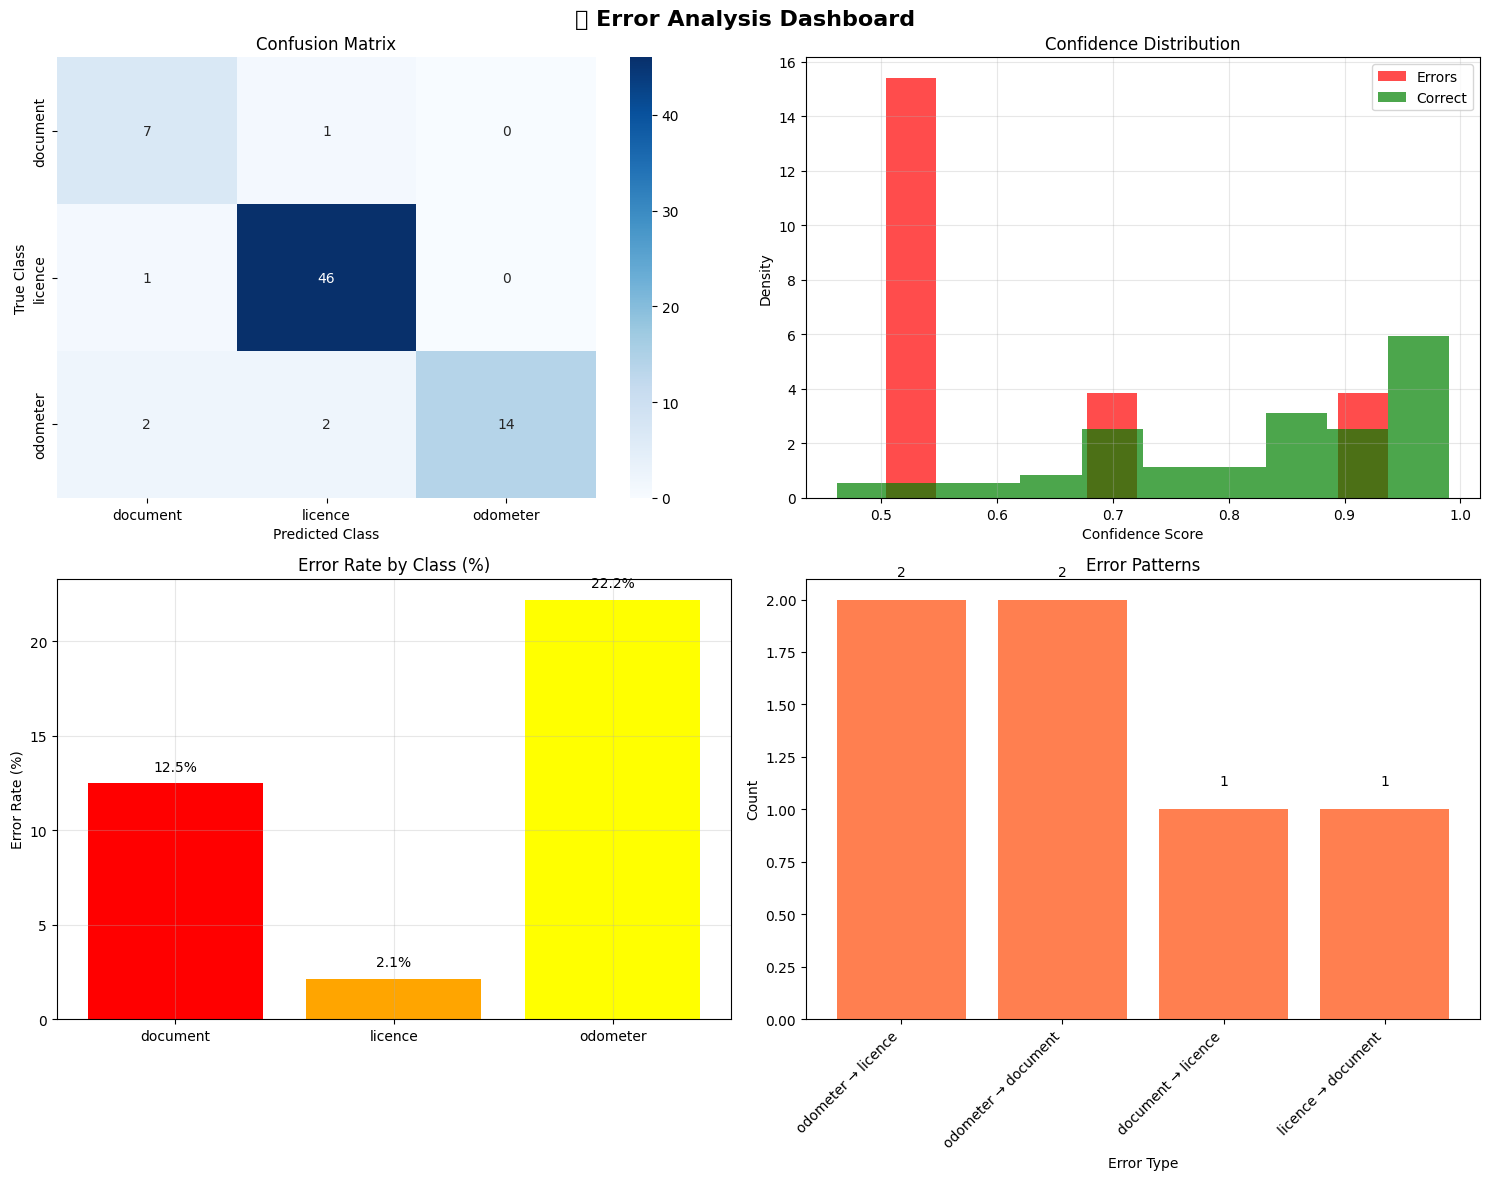

In [22]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🔍 Error Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted Class')
ax1.set_ylabel('True Class')

# 2. Confidence Distribution
ax2 = axes[0, 1]
if error_confidences:
    ax2.hist(error_confidences, bins=10, alpha=0.7, label='Errors', color='red', density=True)
ax2.hist(correct_confidences, bins=10, alpha=0.7, label='Correct', color='green', density=True)
ax2.set_title('Confidence Distribution')
ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Per-Class Error Rates
ax3 = axes[1, 0]
class_error_rates = []
class_names_plot = []
for class_name in CLASS_NAMES:
    class_idx = CLASS_TO_INT[class_name]
    class_total = np.sum(all_ground_truth == class_idx)
    class_errors = np.sum((all_ground_truth == class_idx) & (all_predictions != class_idx))
    if class_total > 0:
        error_rate = class_errors / class_total
        class_error_rates.append(error_rate * 100)
        class_names_plot.append(class_name)

bars = ax3.bar(class_names_plot, class_error_rates, color=['red', 'orange', 'yellow'])
ax3.set_title('Error Rate by Class (%)')
ax3.set_ylabel('Error Rate (%)')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, class_error_rates):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rate:.1f}%', ha='center', va='bottom')

# 4. Error Pattern Breakdown
ax4 = axes[1, 1]
if error_patterns:
    pattern_names = list(error_patterns.keys())
    pattern_counts = [len(cases) for cases in error_patterns.values()]
    
    bars = ax4.bar(range(len(pattern_names)), pattern_counts, color='coral')
    ax4.set_title('Error Patterns')
    ax4.set_xlabel('Error Type')
    ax4.set_ylabel('Count')
    ax4.set_xticks(range(len(pattern_names)))
    ax4.set_xticklabels(pattern_names, rotation=45, ha='right')
    
    # Add value labels
    for bar, count in zip(bars, pattern_counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 str(count), ha='center', va='bottom')
else:
    ax4.text(0.5, 0.5, 'No errors found!', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Error Patterns')

plt.tight_layout()
plt.savefig(MODELS_DIR / 'error_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

🖼️ Visual Inspection of Error Cases


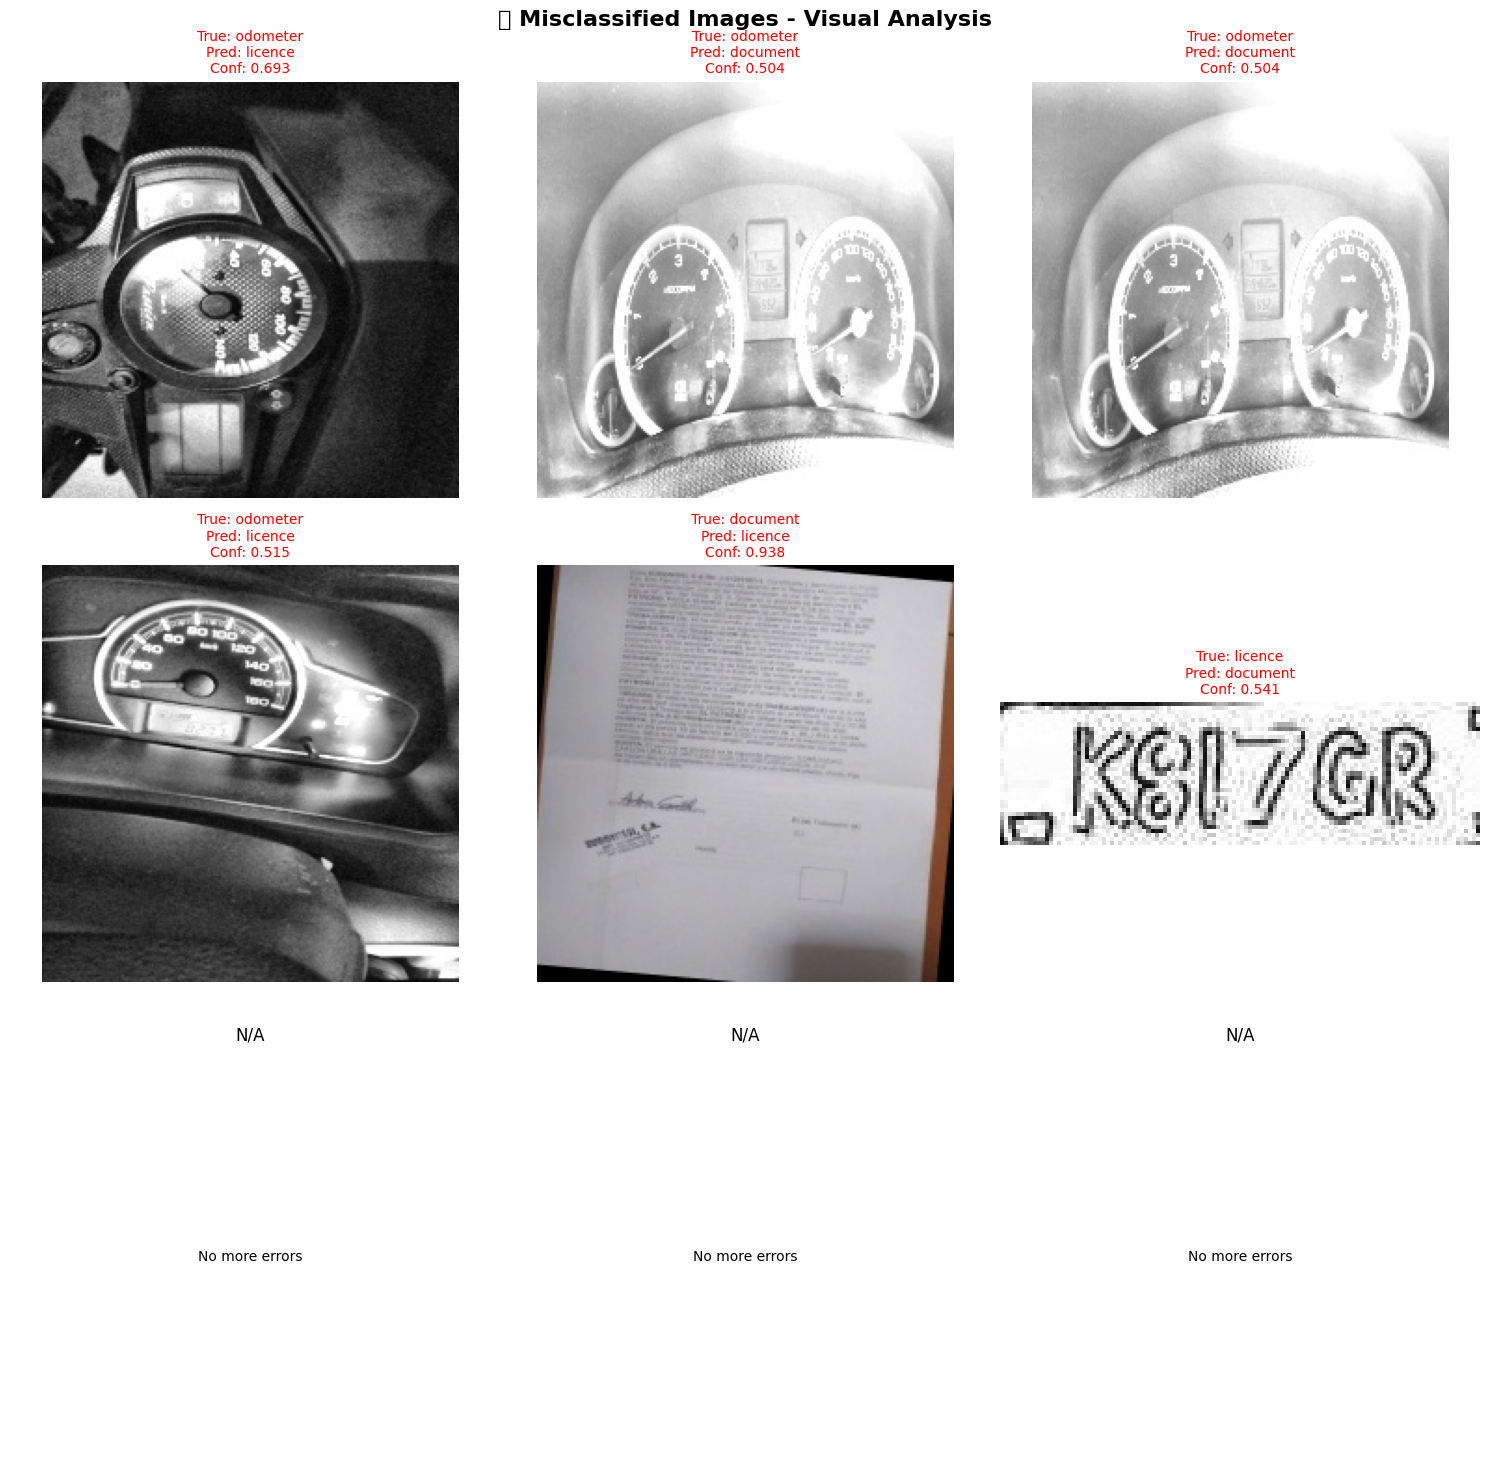

In [23]:
if len(error_cases) > 0:
    print("🖼️ Visual Inspection of Error Cases")
    
    # Display up to 9 error cases
    num_to_show = min(9, len(error_cases))
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('🚨 Misclassified Images - Visual Analysis', fontsize=16, fontweight='bold')
    
    for i in range(9):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        if i < len(error_cases):
            error = error_cases[i]
            
            # Load and display image
            image_path = error['image_path']
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                ax.imshow(image)
                
                # Create detailed title
                title = f"True: {error['true_class']}\n"
                title += f"Pred: {error['predicted_class']}\n"
                title += f"Conf: {error['confidence']:.3f}"
                
                ax.set_title(title, fontsize=10, color='red')
                ax.set_xlabel(Path(image_path).name, fontsize=8)
            else:
                ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
                ax.set_title(f"Error {i+1}", color='red')
        else:
            ax.text(0.5, 0.5, 'No more errors', ha='center', va='center')
            ax.set_title('N/A')
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'error_cases_visual.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("🎉 No errors to visualize - Perfect model!")


In [19]:
print("📊 Detailed Statistical Analysis")

# Calculate detailed metrics per class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_ground_truth, all_predictions, average=None, labels=[0, 1, 2]
)

# Create detailed metrics table
metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Support': support,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Error_Count': [len([e for e in error_cases if e['true_class'] == class_name]) 
                    for class_name in CLASS_NAMES]
})

print("\n📈 Per-Class Performance Metrics:")
print(metrics_df.round(4))

# Analyze confidence thresholds
confidence_thresholds = [0.7, 0.8, 0.9, 0.95]
print(f"\n🎯 Confidence Threshold Analysis:")

for threshold in confidence_thresholds:
    high_conf_mask = np.array([case['confidence'] >= threshold for case in detailed_results])
    if np.sum(high_conf_mask) > 0:
        high_conf_accuracy = np.mean([
            case['is_correct'] for case in detailed_results if case['confidence'] >= threshold
        ])
        coverage = np.sum(high_conf_mask) / len(detailed_results)
        
        print(f"  Threshold {threshold:.2f}: {high_conf_accuracy:.4f} accuracy, "
              f"{coverage:.1%} coverage ({np.sum(high_conf_mask)} samples)")


📊 Detailed Statistical Analysis

📈 Per-Class Performance Metrics:
      Class  Support  Precision  Recall  F1-Score  Error_Count
0  document        8     0.7000  0.8750    0.7778            1
1   licence       47     0.9388  0.9787    0.9583            1
2  odometer       18     1.0000  0.7778    0.8750            4

🎯 Confidence Threshold Analysis:
  Threshold 0.70: 0.9815 accuracy, 74.0% coverage (54 samples)
  Threshold 0.80: 0.9778 accuracy, 61.6% coverage (45 samples)
  Threshold 0.90: 0.9655 accuracy, 39.7% coverage (29 samples)
  Threshold 0.95: 1.0000 accuracy, 20.5% coverage (15 samples)


In [20]:
print("🔍 Root Cause Analysis")

# Analyze error characteristics
print(f"\n📋 Error Characteristics Analysis:")

if len(error_cases) > 0:
    # 1. Low confidence errors (model is uncertain)
    low_conf_errors = [e for e in error_cases if e['confidence'] < 0.7]
    print(f"  Low confidence errors (<0.7): {len(low_conf_errors)}")
    
    # 2. High confidence errors (model is wrong but confident)
    high_conf_errors = [e for e in error_cases if e['confidence'] >= 0.7]
    print(f"  High confidence errors (≥0.7): {len(high_conf_errors)}")
    
    # 3. Close probability errors (confusion between classes)
    close_errors = []
    for error in error_cases:
        probs = error['all_probabilities']
        sorted_probs = sorted(probs, reverse=True)
        if len(sorted_probs) >= 2 and (sorted_probs[0] - sorted_probs[1]) < 0.3:
            close_errors.append(error)
    
    print(f"  Close probability errors (<0.3 margin): {len(close_errors)}")
    
    # 4. Analyze most confused classes
    confusion_pairs = defaultdict(int)
    for error in error_cases:
        pair = tuple(sorted([error['true_class'], error['predicted_class']]))
        confusion_pairs[pair] += 1
    
    print(f"\n🔄 Most Confused Class Pairs:")
    for pair, count in sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True):
        print(f"  {pair[0]} ↔ {pair[1]}: {count} confusions")

🔍 Root Cause Analysis

📋 Error Characteristics Analysis:
  Low confidence errors (<0.7): 5
  High confidence errors (≥0.7): 1
  Close probability errors (<0.3 margin): 4

🔄 Most Confused Class Pairs:
  licence ↔ odometer: 2 confusions
  document ↔ odometer: 2 confusions
  document ↔ licence: 2 confusions


In [30]:
print("💾 Saving Analysis Results...")

# Helper function to ensure JSON serialization
def make_serializable(obj):
    """Convert numpy types to Python native types"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj

# Prepare comprehensive analysis report with safe serialization
analysis_report = {
    'analysis_metadata': {
        'total_test_samples': len(detailed_results),
        'current_accuracy': float(fresh_accuracy),
        'total_errors': len(error_cases),
        'analysis_date': pd.Timestamp.now().isoformat()
    },
    'performance_metrics': {
        'overall_accuracy': float(fresh_accuracy),
        'per_class_metrics': [
            {
                'Class': str(row['Class']),
                'Support': int(row['Support']),
                'Precision': float(row['Precision']),
                'Recall': float(row['Recall']),
                'F1-Score': float(row['F1-Score']),
                'Error_Count': int(row['Error_Count'])
            }
            for _, row in metrics_df.iterrows()
        ],
        'confusion_matrix': conf_matrix.tolist()
    },
    'error_analysis': {
        'error_patterns': {str(k): int(len(v)) for k, v in error_patterns.items()},
        'confidence_analysis': {
            'error_confidences': {
                'mean': float(np.mean(error_confidences)) if error_confidences else 0.0,
                'std': float(np.std(error_confidences)) if error_confidences else 0.0,
                'min': float(np.min(error_confidences)) if error_confidences else 0.0,
                'max': float(np.max(error_confidences)) if error_confidences else 0.0
            },
            'correct_confidences': {
                'mean': float(np.mean(correct_confidences)),
                'std': float(np.std(correct_confidences)),
                'min': float(np.min(correct_confidences)),
                'max': float(np.max(correct_confidences))
            }
        }
    },
    'recommendations': [str(rec) for rec in recommendations]  # Ensure strings
}

# Save error cases separately (simplified version for JSON)
error_cases_json = []
for case in error_cases:
    case_json = {
        'filename': str(case['filename']),
        'true_class': str(case['true_class']),
        'predicted_class': str(case['predicted_class']),
        'confidence': float(case['confidence']),
        'is_correct': bool(case['is_correct']),
        'all_probabilities': [float(p) for p in case['all_probabilities']]
    }
    error_cases_json.append(case_json)

# Add simplified error cases to main report
analysis_report['error_cases'] = error_cases_json

# Make everything serializable
analysis_report = make_serializable(analysis_report)

# Save analysis report
analysis_path = MODELS_DIR / "error_analysis_report.json"
with open(analysis_path, 'w') as f:
    json.dump(analysis_report, f, indent=2)

print(f"✅ Analysis report saved: {analysis_path}")

# Save error cases for further investigation (detailed version)
error_cases_detailed = []
for case in error_cases:
    case_detailed = {
        'image_path': case['image_path'],
        'filename': case['filename'],
        'true_class': case['true_class'],
        'true_class_idx': int(case['true_class_idx']),
        'predicted_class': case['predicted_class'],
        'predicted_idx': int(case['predicted_idx']),
        'confidence': float(case['confidence']),
        'is_correct': bool(case['is_correct']),
        'all_probabilities': [float(p) for p in case['all_probabilities']]
    }
    error_cases_detailed.append(case_detailed)

error_cases_path = MODELS_DIR / "error_cases_detailed.json"
with open(error_cases_path, 'w') as f:
    json.dump(error_cases_detailed, f, indent=2)

print(f"✅ Error cases saved: {error_cases_path}")

print(f"\n🎯 ANALYSIS COMPLETE!")
print(f"📊 Current Performance: {fresh_accuracy*100:.2f}% ({len(error_cases)} errors)")
print(f"🎯 Target Performance: 92%+ (≤6 errors)")
print(f"📈 Improvement Needed: {6 - len(error_cases)} fewer errors")

if len(error_cases) <= 6:
    print(f"🎉 ALREADY CLOSE TO TARGET! Focus on consistency and robustness.")
else:
    print(f"💪 WORK TO DO: Need to fix {len(error_cases) - 6} more errors for 92%+ target")


💾 Saving Analysis Results...
✅ Analysis report saved: ../models/error_analysis_report.json
✅ Error cases saved: ../models/error_cases_detailed.json

🎯 ANALYSIS COMPLETE!
📊 Current Performance: 91.78% (6 errors)
🎯 Target Performance: 92%+ (≤6 errors)
📈 Improvement Needed: 0 fewer errors
🎉 ALREADY CLOSE TO TARGET! Focus on consistency and robustness.
